In [1]:
import numpy as np
import torch
import torchvision
import matplotlib.pyplot as plt
from time import time
from torchvision import datasets, transforms
from torch import nn, optim
import torch.nn.functional as F

### Data

Download the data 

In [145]:
transform = transforms.Compose([transforms.ToTensor(),
                              transforms.Normalize((0.5,), (0.5,)),
                              ])

# Prep the datasets
trainset = datasets.MNIST('MnistData', download=True, train=True, transform=transform)
valset = datasets.MNIST('MnistData', download=True, train=False, transform=transform)

# Feeding for a NN
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)
valloader = torch.utils.data.DataLoader(valset, batch_size=64, shuffle=True)

### Model

Basic CNN model and training

In [ ]:
class mnistnet(nn.Module):
    
    def __init__(self, input_size, hidden1, hidden2, output_size):
        super(mnistnet, self).__init__()
        # Define the layers
        self.conv1 = nn.Conv2d(1, 3, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(3, 9, 5)
        self.fl1 = nn.Linear(input_size, hidden1)
        self.fl2 = nn.Linear(hidden1, hidden2)
        self.fl3 = nn.Linear(hidden2, output_size)
        self.out = nn.LogSoftmax(dim=1)
        
    # Forward pass
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 9 * 4 * 4)
        x = F.relu(self.fl1(x))
        x = F.relu(self.fl2(x))
        x = self.fl3(x)
        return self.out(x)
    
my_network = mnistnet(9 * 4 * 4, 64, 32, 10)

In [146]:
optimizer = optim.SGD(my_network.parameters(), lr=0.003, momentum=0.9)
criterion = nn.NLLLoss()

losses = []
for epoch in range(10):
    running_loss = 0
    for images, labels in trainloader:
        optimizer.zero_grad()
        
        output = my_network.forward(images)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
    losses.append(running_loss)
    print("\rEpoch {} loss {}".format(epoch+1,running_loss), end="")
    


Epoch 10 loss 23.008240826427937

### Score Cam implementation

Score cam is implemented in steps, the method can be found in 

https://arxiv.org/pdf/1910.01279.pdf

1. Start by propagating a input image $x$ past the last conv-layer and extract $k$ number of feature maps

2. Upscale those feature maps to the original image size

3. Normalize each mask with $A^k = \frac{A^k_{i,j}}{max(A^k) - min(A^k)}$

4. Project maps to original image and pass thru the network as $f(x \otimes A)$

5. Obtain a weight $w^k$ for each of the masks defined as NN output 

6. Calculate final mask as $c_{final}=ReLU(\sum w^k * A^k)$

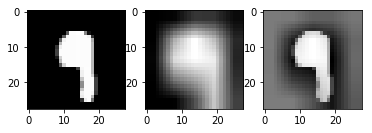

In [308]:
conv_part = [my_network._modules[l] for l in ["conv1", "pool", "conv2"]]
image_index = 10

test_img = images[image_index].reshape(1,1,28,28)
test_target = labels[image_index].item()

# 1. Pass input image only thru the convolutional layers
x = conv_part[1](F.relu(conv_part[0](test_img)))
x = conv_part[1](F.relu(conv_part[2](x)))
x = F.interpolate(x, size=(28,28), mode='bilinear')
_,k,_,_ = x.shape

# 2. Normalize the masks
# 3. Project masks to original image
masked_images = []
for i in range(k):
    maxA = max(x[0,i,:].flatten())
    minA = min(x[0,i,:].flatten())
    x[0,i,:] /= (maxA-minA + 1e-4)
    masked_images.append(test_img * x[:,i,:,:])
    
# 4. Pass masks through the original network and calculate score
weight_scores = [i[test_target] for i in np.exp(my_network(torch.cat(masked_images)).detach().numpy())]

# 5. Construct the final mask to be projected
final_mask = torch.Tensor(np.zeros((28,28)))
for i in range(k):
    final_mask += F.relu(x[0,i,:] * torch.Tensor([weight_scores[i]]))

# Visualize result
plt.figure()
plt.subplot(1,3,1)
plt.imshow(test_img.reshape(28,28), cmap="gray")

plt.subplot(1,3,2)
plt.imshow(final_mask.detach().numpy().reshape(28,28), cmap="gray")

plt.subplot(1,3,3)
final_cam = test_img.detach().numpy().reshape(28,28) * final_mask.detach().numpy()
plt.imshow(final_cam, cmap="gray")

In the b/w image is hard to see where the filter works

we can instead use 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


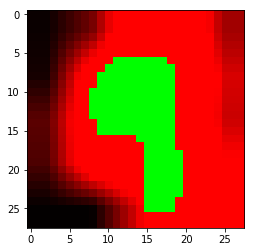

In [274]:
inp = test_img.detach().numpy().reshape(28,28)
empty_img = np.zeros((28,28,3))

for i in range(28):
    for j in range(28):
        if inp[i][j] == -1:
            empty_img[i][j][0] = 1
        else:
            empty_img[i][j][1] = 1
            
for i in range(3):
    empty_img[:,:,i] *= final_mask.detach().numpy()
plt.imshow(empty_img)

In [ ]:
masked_images

In [307]:
final_mask = (x[0,:,:,:].view(28,28,9) * torch.Tensor(weight_scores)).sum(dim=2)
